# Imports



In [143]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Input, BatchNormalization, Activation, concatenate
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from keras import Sequential
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import tensorflow

# Global functions

In [144]:
def output_metrics(model, test_data, test_labels):
  predictions = model.predict(test_data)

  y_pred  = np.argmax(predictions, axis=-1)

  print(f'Accuracy score: {accuracy_score(test_labels, y_pred)}')
  print(f'F1 score: {f1_score(test_labels, y_pred, average="weighted")}')
  print(f'Precision score: {precision_score(test_labels, y_pred, average="weighted")}')
  print(f'Recall score: {recall_score(test_labels, y_pred, average="weighted")}')

In [145]:
def read_and_resize_image(image_path, size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    return img

# Loading dataset

In [146]:
!pip install -q kaggle
from google.colab import files 

In [147]:
files.upload()

Saving kaggle.json to kaggle (5).json


{'kaggle.json': b'{"username":"johnk27","key":"00b3f1fe3fa0259eb805e8fe2dd1eb02"}'}

In [148]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [149]:
!cp kaggle.json ~/.kaggle/

In [150]:
!chmod 600 ~/.kaggle/kaggle.json

In [151]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.18G/5.20G [00:55<00:00, 241MB/s]
100% 5.20G/5.20G [00:55<00:00, 99.9MB/s]


In [152]:
!unzip -q skin-cancer-mnist-ham10000.zip -d content

replace content/HAM10000_images_part_1/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [153]:
# Remove zip
!rm skin-cancer-mnist-ham10000.zip

In [154]:
df = pd.read_csv('content/HAM10000_metadata.csv')

In [234]:
print(df)

         lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                                  path  \
0    

In [235]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,content/HAM10000_images_part_1/ISIC_0027419.jpg,Bening keratosis-like lesions,2,"[[[197, 156, 193], [194, 152, 188], [190, 145,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,content/HAM10000_images_part_1/ISIC_0025030.jpg,Bening keratosis-like lesions,2,"[[[25, 12, 21], [27, 14, 23], [42, 25, 36], [7..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,content/HAM10000_images_part_1/ISIC_0026769.jpg,Bening keratosis-like lesions,2,"[[[138, 129, 185], [148, 134, 191], [160, 147,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,content/HAM10000_images_part_1/ISIC_0025661.jpg,Bening keratosis-like lesions,2,"[[[17, 10, 23], [30, 20, 34], [47, 35, 63], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,content/ham10000_images_part_2/ISIC_0031633.jpg,Bening keratosis-like lesions,2,"[[[117, 94, 139], [139, 114, 158], [163, 134, ..."


In [236]:
df.describe()

,age,cell_type_idx
count,9958.000000,9958.000000
mean,51.863828,3.623619
std,16.968614,1.210800
min,0.000000,0.000000
25%,40.000000,4.000000
50%,50.000000,4.000000
75%,65.000000,4.000000
max,85.000000,6.000000


In [237]:
df.localization.unique()

array(['scalp', 'ear', 'face', 'back', 'trunk', 'chest',
       'upper extremity', 'abdomen', 'unknown', 'lower extremity',
       'genital', 'neck', 'hand', 'foot', 'acral'], dtype=object)

# Pre-processing

In [238]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Bening keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
raw_images = 'content'

In [239]:
from glob import glob

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(raw_images, '*', '*.jpg'))}

In [240]:
print(os.path.join(raw_images, '*', '*.jpg'))

content/*/*.jpg


In [241]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [242]:
# Fill in the null values with the average age
df['age'].fillna((df['age'].mean()), inplace=True)

In [243]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
image            0
dtype: int64

In [244]:
df = df.dropna()

In [245]:
image_size = (64, 64)

In [246]:
# Apply the function to each image path in the 'path' column of the dataframe
df['image'] = df['path'].apply(lambda x: read_and_resize_image(x, image_size))

In [247]:
df['image'].map(lambda x: x.shape).value_counts()

(64, 64, 3)    9958
Name: image, dtype: int64

In [248]:
from sklearn.model_selection import train_test_split
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cell_type_idx'], random_state=42)

In [249]:
train_df = train_df.reset_index()  # make sure indexes pair with number of rows

In [250]:
print(train_df)

      index    lesion_id      image_id     dx    dx_type   age     sex  \
0      5649  HAM_0003963  ISIC_0027448     nv  follow_up  45.0  female   
1        29  HAM_0001480  ISIC_0031753    bkl      histo  70.0    male   
2      8367  HAM_0000597  ISIC_0030654     nv      histo  35.0  female   
3      9841  HAM_0002615  ISIC_0033413  akiec      histo  70.0    male   
4      1429  HAM_0001729  ISIC_0024537    mel      histo  85.0    male   
...     ...          ...           ...    ...        ...   ...     ...   
7961   5022  HAM_0005841  ISIC_0027804     nv  follow_up  50.0  female   
7962   3768  HAM_0007408  ISIC_0028377     nv  follow_up   5.0    male   
7963   9509  HAM_0004705  ISIC_0034260     nv  consensus  65.0    male   
7964   3341  HAM_0001810  ISIC_0025794     nv  follow_up  45.0  female   
7965   3697  HAM_0005218  ISIC_0028939     nv  follow_up  55.0  female   

         localization                                             path  \
0     lower extremity  content/HAM100

In [251]:
train_df['image'].map(lambda x: x.shape).value_counts()

(64, 64, 3)    7966
Name: image, dtype: int64

# Individual

In [252]:
# Extract the image data and target labels for train and test sets
X_train_img = np.stack(train_df['image'].values)
y_train = train_df['cell_type_idx'].values
X_test_img = np.stack(test_df['image'].values)
y_test = test_df['cell_type_idx'].values

In [253]:
def cnn():
  model = Sequential()
  model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Dropout(0.6))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))
  return model

In [254]:
cnn = cnn()
cnn.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

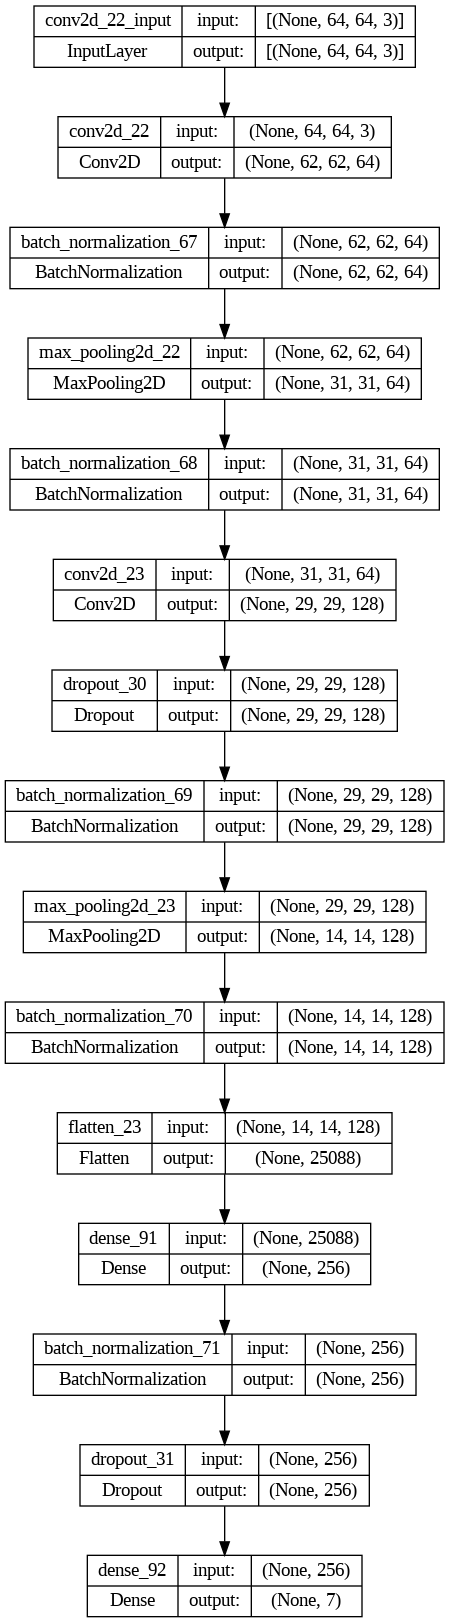

In [255]:
plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [256]:
cnn.fit(X_train_img, y_train, batch_size=256, epochs=50, validation_split=0.3)

Epoch 1/50
22/22 [==============================] - 7s 130ms/step - loss: 2.4804 - accuracy: 0.4005 - val_loss: 13.6094 - val_accuracy: 0.5544
Epoch 2/50
22/22 [==============================] - 2s 110ms/step - loss: 1.5634 - accuracy: 0.5577 - val_loss: 7.0654 - val_accuracy: 0.6644
Epoch 3/50
22/22 [==============================] - 2s 109ms/step - loss: 1.2968 - accuracy: 0.6478 - val_loss: 3.9429 - val_accuracy: 0.6502
Epoch 4/50
22/22 [==============================] - 3s 120ms/step - loss: 1.0668 - accuracy: 0.6964 - val_loss: 1.7733 - val_accuracy: 0.6389
Epoch 5/50
22/22 [==============================] - 2s 110ms/step - loss: 0.9639 - accuracy: 0.7313 - val_loss: 1.5976 - val_accuracy: 0.6745
Epoch 6/50
22/22 [==============================] - 2s 110ms/step - loss: 0.8502 - accuracy: 0.7369 - val_loss: 1.4692 - val_accuracy: 0.6720
Epoch 7/50
22/22 [==============================] - 3s 117ms/step - loss: 0.7648 - accuracy: 0.7647 - val_loss: 1.0771 - val_accuracy: 0.6879
Epoch

In [257]:
# Use the trained model to make predictions on the test data
output_metrics(cnn, X_test_img, y_test)

63/63 [==============================] - 0s 4ms/step
Accuracy score: 0.695281124497992
F1 score: 0.7043665648560229
Precision score: 0.7217150273169449
Recall score: 0.695281124497992


In [258]:
def perceptron():
  model = Sequential()
  model.add(Input(shape=(3,)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))
  return model

In [259]:
perceptron = perceptron()
perceptron.compile(optimizer = 'adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

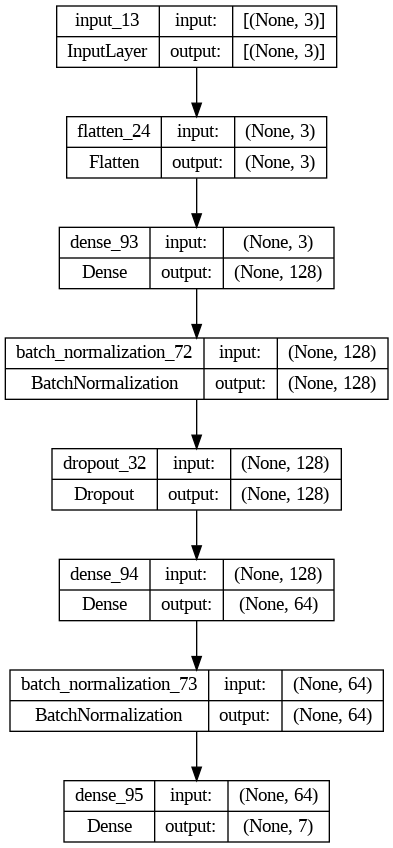

In [260]:
plot_model(perceptron, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [261]:
sex_dict = {
    'male': 0.0,
    'female': 1.0,
    'unknown': 1.5
}

loc_dict = {
    'back': 1.0,
    'lower extremity': 2.0,
    'trunk': 3.0,
    'upper extremity': 4.0,
    'abdomen': 5.0,
    'face': 6.0,
    'chest': 7.0,
    'foot': 8.0,
    'unknown': 9.0,
    'neck': 10.0,
    'scalp': 11.0,
    'hand': 12.0,
    'ear': 13.0,
    'genital': 14.0,
    'acral': 15.0
}

In [262]:
train_df = train_df.replace({"sex": sex_dict})
train_df = train_df.replace({"localization": loc_dict})
test_df = test_df.replace({"sex": sex_dict})
test_df = test_df.replace({"localization": loc_dict})

In [263]:
#Extract and recombine the demographic data for training set and test set
X_train_demo = np.stack((np.asarray(train_df['age'].values), np.asarray(train_df['sex'].values), np.asarray(train_df['localization'].values)))
y_train = train_df['cell_type_idx'].values
X_test_demo = np.stack((np.asarray(test_df['age'].values), np.asarray(test_df['sex'].values), np.asarray(test_df['localization'].values)))
y_test = test_df['cell_type_idx'].values

X_train_demo=X_train_demo.T.astype(int)
X_test_demo=X_test_demo.T.astype(int)

In [264]:
perceptron.fit(X_train_demo, y_train, batch_size=256, epochs=50, validation_split=0.3)

Epoch 1/50
22/22 [==============================] - 3s 20ms/step - loss: 2.0097 - accuracy: 0.3589 - val_loss: 6.6594 - val_accuracy: 0.1356
Epoch 2/50
22/22 [==============================] - 0s 9ms/step - loss: 1.6894 - accuracy: 0.5425 - val_loss: 6.7937 - val_accuracy: 0.1536
Epoch 3/50
22/22 [==============================] - 0s 7ms/step - loss: 1.5478 - accuracy: 0.5757 - val_loss: 5.4916 - val_accuracy: 0.1628
Epoch 4/50
22/22 [==============================] - 0s 6ms/step - loss: 1.4371 - accuracy: 0.5986 - val_loss: 3.8423 - val_accuracy: 0.2565
Epoch 5/50
22/22 [==============================] - 0s 6ms/step - loss: 1.3460 - accuracy: 0.6230 - val_loss: 2.6991 - val_accuracy: 0.3377
Epoch 6/50
22/22 [==============================] - 0s 9ms/step - loss: 1.2649 - accuracy: 0.6275 - val_loss: 1.9288 - val_accuracy: 0.4464
Epoch 7/50
22/22 [==============================] - 0s 7ms/step - loss: 1.1788 - accuracy: 0.6435 - val_loss: 1.4754 - val_accuracy: 0.5632
Epoch 8/50
22/22 [=

In [265]:
# Use the trained model to make predictions on the test data
output_metrics(perceptron, X_test_demo, y_test)

63/63 [==============================] - 0s 2ms/step
Accuracy score: 0.6696787148594378
F1 score: 0.5507888078098414
Precision score: 0.4896959640857673
Recall score: 0.6696787148594378


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Combined 1 - Training the combined model with the previously trained CNN and perceptron

In [266]:
concatenated_inputs = concatenate(inputs=[perceptron.output, cnn.output])
x = Dense(128, activation="relu")(concatenated_inputs)
x = Dense(64, activation="relu")(x)
x = Dense(len(df['cell_type_idx'].unique()), activation='softmax')(x)
model = Model(inputs=[perceptron.input, cnn.input], outputs=x)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [267]:
model.fit([X_train_demo, X_train_img], y_train, batch_size=256, epochs=50, validation_split=0.3)

Epoch 1/50
22/22 [==============================] - 9s 134ms/step - loss: 1.4356 - accuracy: 0.7278 - val_loss: 1.2082 - val_accuracy: 0.7071
Epoch 2/50
22/22 [==============================] - 3s 120ms/step - loss: 0.6735 - accuracy: 0.8608 - val_loss: 0.8759 - val_accuracy: 0.7163
Epoch 3/50
22/22 [==============================] - 3s 115ms/step - loss: 0.3485 - accuracy: 0.9179 - val_loss: 1.1875 - val_accuracy: 0.7000
Epoch 4/50
22/22 [==============================] - 3s 121ms/step - loss: 0.2755 - accuracy: 0.9320 - val_loss: 1.4265 - val_accuracy: 0.6623
Epoch 5/50
22/22 [==============================] - 3s 119ms/step - loss: 0.2346 - accuracy: 0.9362 - val_loss: 1.2749 - val_accuracy: 0.7042
Epoch 6/50
22/22 [==============================] - 3s 120ms/step - loss: 0.2266 - accuracy: 0.9383 - val_loss: 1.4605 - val_accuracy: 0.6690
Epoch 7/50
22/22 [==============================] - 2s 113ms/step - loss: 0.1939 - accuracy: 0.9469 - val_loss: 1.5480 - val_accuracy: 0.6059
Epoch 

In [268]:
output_metrics(model, [X_test_demo, X_test_img], y_test)

63/63 [==============================] - 0s 5ms/step
Accuracy score: 0.7464859437751004
F1 score: 0.7158683689991896
Precision score: 0.7175422964347375
Recall score: 0.7464859437751004


# Combined 2 - Training the combined model from scratch

In [269]:
def cnn():
  model = Sequential()
  model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Dropout(0.6))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2, 2)))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))
  model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))
  return model

def perceptron():
  model = Sequential()
  model.add(Input(shape=(3,)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(len(df['cell_type_idx'].unique()), activation='softmax'))
  return model

In [270]:
perceptron = perceptron()
cnn = cnn()
#create an input for the final layers from the concatenated outputs of both subnetworks
combinedInput = concatenate(inputs=[perceptron.output, cnn.output])

#simple Multi-Layer Perceptron with Dense Layers
x = Dense(128, activation="relu")(combinedInput)
x = Dense(64, activation="relu")(x)
x = Dense(len(df['cell_type_idx'].unique()), activation='softmax')(x)
model = Model(inputs=[perceptron.input, cnn.input], outputs=x)

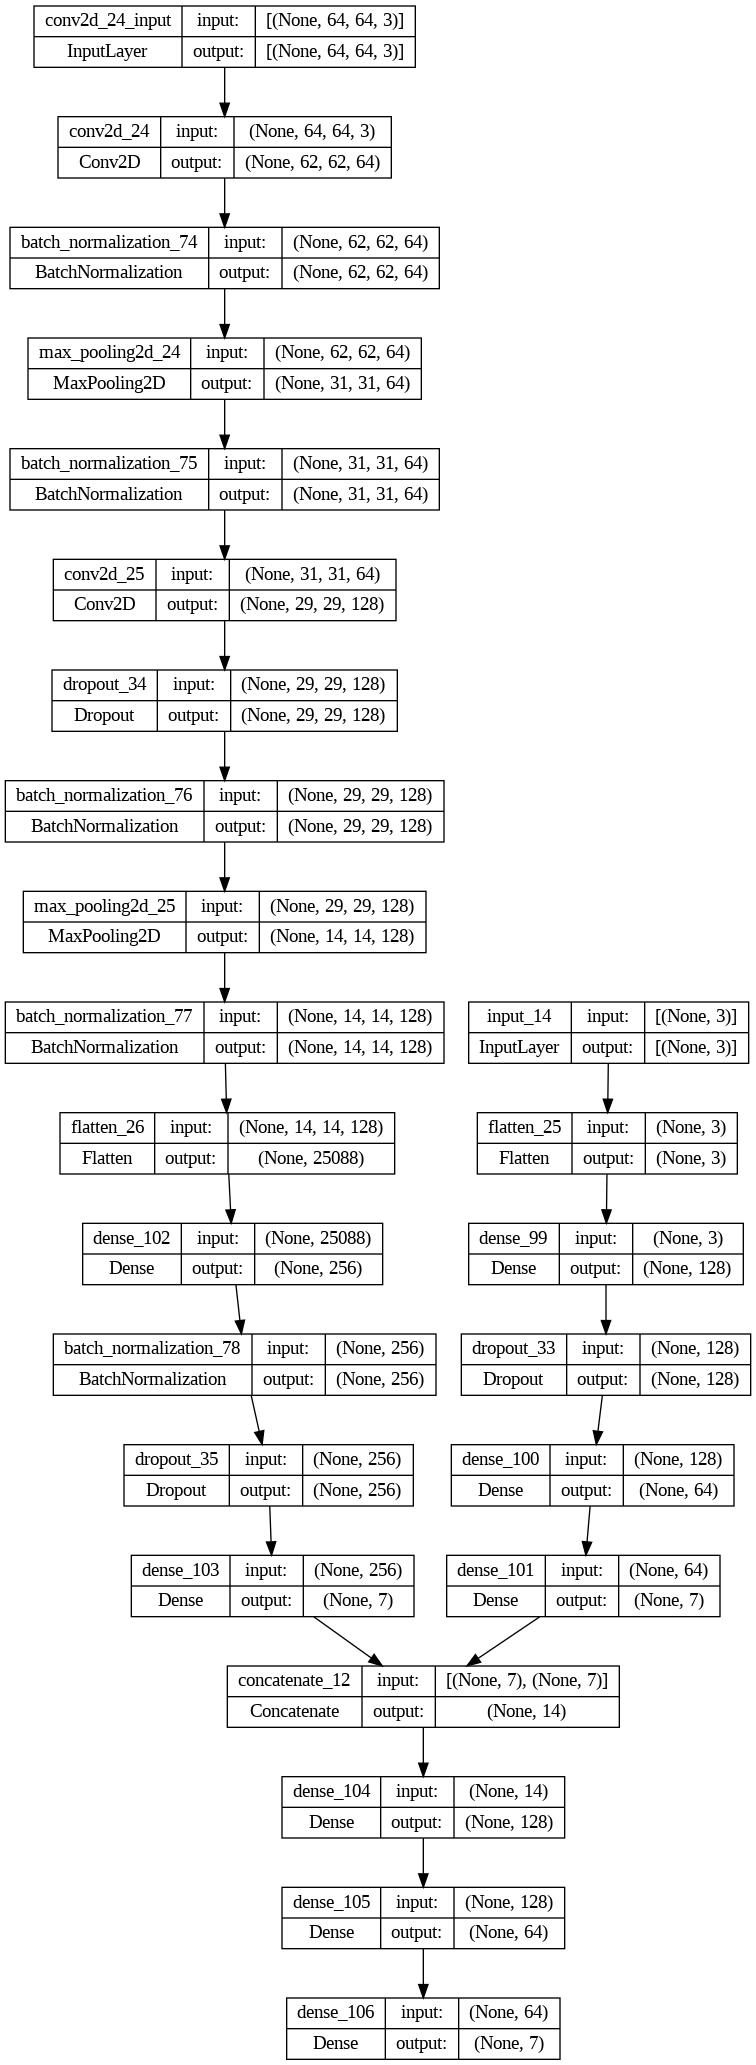

In [271]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [272]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

model.fit([X_train_demo, X_train_img], y_train, batch_size=256, epochs=50, validation_split=0.3)

Epoch 1/50
22/22 [==============================] - 8s 133ms/step - loss: 1.4343 - accuracy: 0.6280 - val_loss: 1.1804 - val_accuracy: 0.6657
Epoch 2/50
22/22 [==============================] - 3s 118ms/step - loss: 1.0389 - accuracy: 0.6702 - val_loss: 1.1513 - val_accuracy: 0.6657
Epoch 3/50
22/22 [==============================] - 3s 120ms/step - loss: 0.9245 - accuracy: 0.6702 - val_loss: 1.0359 - val_accuracy: 0.6657
Epoch 4/50
22/22 [==============================] - 2s 112ms/step - loss: 0.8648 - accuracy: 0.6779 - val_loss: 1.1874 - val_accuracy: 0.6657
Epoch 5/50
22/22 [==============================] - 2s 111ms/step - loss: 0.8225 - accuracy: 0.6901 - val_loss: 1.1313 - val_accuracy: 0.6657
Epoch 6/50
22/22 [==============================] - 3s 118ms/step - loss: 0.8019 - accuracy: 0.6957 - val_loss: 1.0311 - val_accuracy: 0.6657
Epoch 7/50
22/22 [==============================] - 2s 112ms/step - loss: 0.7874 - accuracy: 0.7041 - val_loss: 1.0856 - val_accuracy: 0.6678
Epoch 

In [273]:
output_metrics(model, [X_test_demo, X_test_img], y_test)

63/63 [==============================] - 0s 4ms/step
Accuracy score: 0.7188755020080321
F1 score: 0.6863614194624202
Precision score: 0.6652701407102352
Recall score: 0.7188755020080321
